Partie 1 : Extraction des Données

In [76]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import time
import math
from selenium import webdriver
from selenium.webdriver import ActionChains
from selenium.webdriver.chrome.service import Service  
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import folium
from geopy.exc import GeocoderUnavailable
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
import re


In [9]:
s = Service('C:/Users/bengu/OneDrive/Bureau/IA Master M1/Programmation/Webscraping/chromedriver-win64/chromedriver.exe')
driver = webdriver.Chrome(service=s)
driver.get("https://www.google.com/")

#Refuser les cookies google
time.sleep(1) 
button_cookies = driver.find_element(By.ID, "W0wltc").click()

#Rechercher le site
time.sleep(1) 
search_box = driver.find_element(By.CSS_SELECTOR, "textarea[name='q']")
search_box.send_keys("schlouk map.com")
search_box.send_keys(Keys.RETURN)

#Cliquer sur le site
time.sleep(1) 
button_site = driver.find_element(By.XPATH, "//a[contains(text(), 'Liste des villes')]").click()


# driver.get("https://www.schlouk-map.com/fr/cities/toulouse/happy-hour")
#Passer les coockies
time.sleep(1) 
button_cookies = driver.find_element(By.CLASS_NAME, "fc-button-label").click()

#Rechercher Toulouse
sleep  = time.sleep(1) 
search_bar = driver.find_element(By.CSS_SELECTOR, "input[type='search']").send_keys("Toulouse")
sleep  = time.sleep(1) 
button_toulouse = driver.find_element(By.CLASS_NAME, "js-searchBox-results-item-content").click()

#Passer l'annonce google
sleep  = time.sleep(1)
action = ActionChains(driver)
action.move_by_offset(500, 500)
action.click()
action.perform()

#Clicker sur happy hour
sleep  = time.sleep(1) 
button_happyhours = driver.find_element(By.XPATH, "//a[@href='/fr/cities/toulouse/happy-hour']")
button_happyhours.click()

time.sleep(1) 
urls = []
urls.append(driver.current_url)

url_site = driver.current_url
time.sleep(1)

#Boutton suivant
while True:
    try:
        button_suivant = driver.find_element(By.XPATH, "//a[contains(text(), 'Suivant')]")
        if button_suivant:
            driver.execute_script("arguments[0].click();", button_suivant)
            time.sleep(1)
            urls.append(driver.current_url)
    except:
        break

#Combiner les urls pages
html_page = ''
for url in urls:
    html_page_text = requests.get(url).text
    html_page += html_page_text
soup = BeautifulSoup(html_page, "html.parser")
    
#Récuperer les urls bars
url_bars = soup.find_all("h2", class_="h4 mb-0 text-truncate")
url_bars_list = []
for url_bar in url_bars:
    href_bars = url_bar.find_all("a", href=True)
    for href_bar in href_bars:
        url_bars_list.append(href_bar['href'])
print(url_bars_list)
print(url_site)


concatenated_urls = [url_site.rsplit("/cities/", 1)[0] + url.replace("/fr", "", 1) for url in url_bars_list]

# Liste des url
for url in concatenated_urls:
    print(url)



['/fr/places/matabiau-decapsule-club', '/fr/places/tom-pouce', '/fr/places/the-black-lion-1', '/fr/places/barricot', '/fr/places/la-maison-1', '/fr/places/el-circo', '/fr/places/o-boudu-pont', '/fr/places/le-tchin', '/fr/places/the-botanist-pub', '/fr/places/le-pery', '/fr/places/le-biergarten', '/fr/places/cafe-oz-2', '/fr/places/the-frog-rosbif-2', '/fr/places/the-petit-london', '/fr/places/the-danu', '/fr/places/snapper-rock', '/fr/places/the-hopscotch', '/fr/places/le-bistrologue', '/fr/places/1862-artybar', '/fr/places/kraken-paradise', '/fr/places/mad-meet-and-drink', '/fr/places/le-delicatessen', '/fr/places/bar-martini-club', '/fr/places/borriquito-loco', '/fr/places/lautruche', '/fr/places/sauvage-social-pub', '/fr/places/beer-mosaic', '/fr/places/lalmanach-bistrot', '/fr/places/le-saint-des-seins', '/fr/places/la-tireuse', '/fr/places/the-london-town', '/fr/places/la-tantina-de-burgos', '/fr/places/rooster-beer', '/fr/places/cacahuete', '/fr/places/au-fut-et-a-mesure-7', '/fr

In [10]:
all_contents = ""

for url in concatenated_urls:
    response = requests.get(url)
    if response.status_code == 200:
        all_contents += response.text

soup_all_contents = BeautifulSoup(all_contents, "html.parser")

In [54]:
nom_bar = soup_all_contents.find_all(class_="mb-0 d-inline-block")

location_bar = soup.find_all('p', class_="text-truncate mb-0 text-secondary")

prix_bar = soup.find_all('p', class_="text-truncate mb-2 text-secondary")

horaires_bar = soup_all_contents.find_all(class_="col-lg-6 mb-3 mb-md-0")

services_bar = soup_all_contents.find_all(class_="table table-sm table-borderless table-services mb-0")


In [75]:
data = []

for nom, prix, horaires, services, location, url in zip(nom_bar, prix_bar, horaires_bar, services_bar, location_bar, concatenated_urls):
    nom_text = nom.get_text().strip().replace("\n", " ") if nom else ""
    horaires_text = horaires.get_text().strip().replace("Ouverture", "").replace("\n", " ") if horaires else ""
    services_text = ", ".join([service.strip().replace("Oui", "").strip() for service in services.get_text().strip().split("\n") if "Oui" in service])
    location_text = location.get_text().strip().replace("\n", " ") if location else ""
    prix_text = prix.get_text().strip().replace("\n", " ") if location else ""
    
    prix_match = re.search(r'(\d+,\d+)', prix_text)
    prix_happy_hour = float(prix_match.group(1).replace(",", ".")) if prix_match else None

    data.append([nom_text, horaires_text, url, services_text, prix_happy_hour, location_text])

df = pd.DataFrame(data, columns=['Bar', 'Horaires', 'Lien', 'Services (Oui)', 'Tarif Happy Hour (€)', 'Localisation'])

df


,Bar,Horaires,Lien,Services (Oui),Tarif Happy Hour (€),Localisation
0,Matabiau Décapsule Club,Lundi 15:30 - 20:00 Mardi 13:00 - 23:00 M...,https://www.schlouk-map.com/fr/places/matabiau...,"Vente à emporter, Wifi gratuit, Diffusion de m...",3.7,"74 Rue Matabiau, 31000 Toulouse"
1,Tom Pouce,Lundi 10:30 - 20:00 Mardi 10:30 - 20:00 M...,https://www.schlouk-map.com/fr/places/tom-pouce,"Restauration, Vente à emporter, Wifi gratuit, ...",5.5,"4 Place Roger Salengro, 31000 Toulouse"
2,The Black Lion,Lundi 08:30 - 02:00 Mardi 08:30 - 02:00 M...,https://www.schlouk-map.com/fr/places/the-blac...,"Restauration, Vente à emporter, 🌬 Air climatis...",4.8,"4 Allées Paul Feuga, 31000 Toulouse"
3,Barricot,Lundi 12:00 - 22:00 Mardi 12:00 - 22:00 M...,https://www.schlouk-map.com/fr/places/barricot,"Restauration, Vente à emporter",8.0,"8 Esp. Compans Caffarelli, 31000 Toulouse"
4,La Maison,Lundi 17:30 - 02:00 Mardi 17:30 - 02:00 M...,https://www.schlouk-map.com/fr/places/la-maison-1,"Restauration, Vente à emporter, DJ Mix",4.0,"9 Rue Gabriel Pérri, 31000 Toulouse"
...,...,...,...,...,...,...
62,The Melting Pot Pub,Lundi 12:00 - 02:00 Mardi 12:00 - 02:00 M...,https://www.schlouk-map.com/fr/places/the-melt...,"Restauration, Diffusion de matchs, 🌬 Air clima...",4.7,"26 Boulevard de Strasbourg, 31000 Toulouse"
63,Les Tricheurs,Lundi 17:00 - 01:00 Mardi 17:00 - 01:00 M...,https://www.schlouk-map.com/fr/places/les-tric...,,4.0,"34 Rue des Blanchers, 31000 Toulouse"
64,Baraka Jeux,Lundi 17:00 - 01:00 Mardi 17:00 - 01:00 M...,https://www.schlouk-map.com/fr/places/baraka-j...,"Restauration, Vente à emporter",3.9,"1 Boulevard de la Gare, 31500 Toulouse"
65,Dada,Lundi 18:00 - 00:00 Mardi 18:00 - 02:00 M...,https://www.schlouk-map.com/fr/places/dada,"Restauration, Vente à emporter, Diffusion de m...",4.0,"27 Avenue Honoré Serres, 31000 Toulouse"


Partie 2 : Analyse des Données

Les cinq bars proposant les meilleurs deals durant les happy hours sont :
                   Bar  Tarif Happy Hour (€)
66        Le Filochard                   3.0
34  Au Fût et à Mesure                   3.0
13    The Petit London                   3.0
28  Le Saint des Seins                   3.3
18        1862 Artybar                   3.3


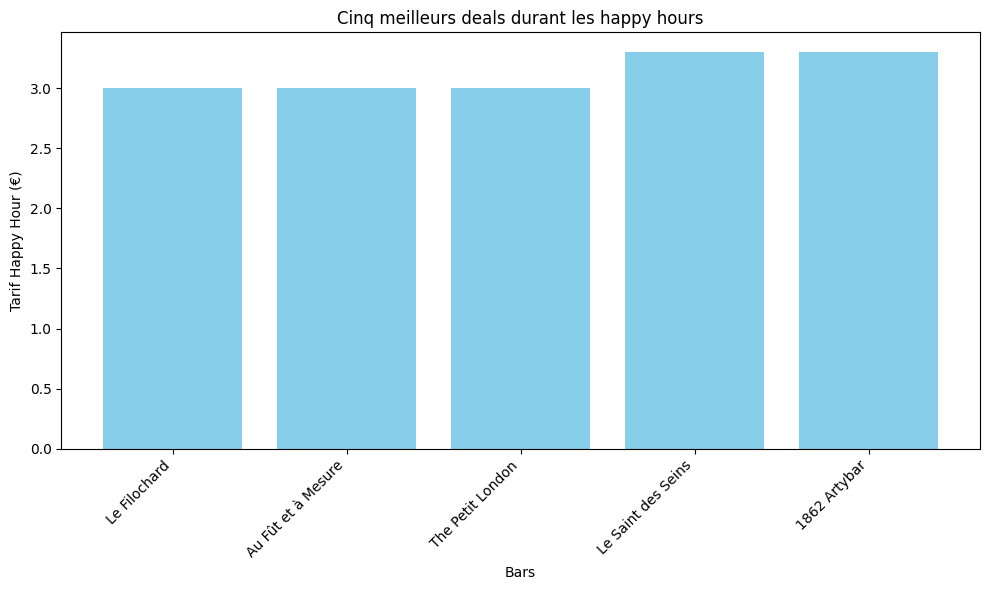

In [90]:
import matplotlib.pyplot as plt

df_sorted = df.sort_values(by='Tarif Happy Hour (€)', ascending=True)

meilleurs_deals_happy_hours = df_sorted.head(5)

print("Les cinq bars proposant les meilleurs deals durant les happy hours sont :")
print(meilleurs_deals_happy_hours[['Bar', 'Tarif Happy Hour (€)']])

plt.figure(figsize=(10, 6))
plt.bar(meilleurs_deals_happy_hours['Bar'], meilleurs_deals_happy_hours['Tarif Happy Hour (€)'], color='skyblue')
plt.xlabel('Bars')
plt.ylabel('Tarif Happy Hour (€)')
plt.title('Cinq meilleurs deals durant les happy hours')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Partie 3 : Rapport par E-mail 

In [91]:
bar = [
    {'name': df_sorted.iloc[0]['Bar'], 'address': df_sorted.iloc[0]['Localisation'], 'happy_hour_price': df_sorted.iloc[0]['Tarif Happy Hour (€)']},
    {'name': df_sorted.iloc[1]['Bar'], 'address': df_sorted.iloc[1]['Localisation'], 'happy_hour_price': df_sorted.iloc[1]['Tarif Happy Hour (€)']},
    {'name': df_sorted.iloc[2]['Bar'], 'address': df_sorted.iloc[2]['Localisation'], 'happy_hour_price': df_sorted.iloc[2]['Tarif Happy Hour (€)']},
    {'name': df_sorted.iloc[3]['Bar'], 'address': df_sorted.iloc[3]['Localisation'], 'happy_hour_price': df_sorted.iloc[3]['Tarif Happy Hour (€)']},
    {'name': df_sorted.iloc[4]['Bar'], 'address': df_sorted.iloc[4]['Localisation'], 'happy_hour_price': df_sorted.iloc[4]['Tarif Happy Hour (€)']}
]

print(bar)

[{'name': 'Le Filochard', 'address': '8 Place du Pont Neuf, 31000 Toulouse', 'happy_hour_price': 3.0}, {'name': 'Au Fût et à Mesure', 'address': '20 Rue Gabriel Péri, 31000 Toulouse', 'happy_hour_price': 3.0}, {'name': 'The Petit London', 'address': '7 Rue Riquet, 31000 Toulouse', 'happy_hour_price': 3.0}, {'name': 'Le Saint des Seins', 'address': '5 Place Saint-Pierre, 31000 Toulouse', 'happy_hour_price': 3.3}, {'name': '1862 Artybar', 'address': '24 Rue Nicolas Bachelier, 31000 Toulouse', 'happy_hour_price': 3.3}]


In [93]:
import smtplib
from email.mime.text import MIMEText
from jinja2 import Template

port = 587
smtp_server = "live.smtp.mailtrap.io"
login = "api" 
password = "0ed989f473b83a94c6e1e66607808e37"

sender_email = "mailtrap@demomailtrap.com"
receiver_email = "romain.benguigui.edu@groupe-gema.com"

bar = [
    {'name': df_sorted.iloc[0]['Bar'], 'address': df_sorted.iloc[0]['Localisation'], 'happy_hour_price': df_sorted.iloc[0]['Tarif Happy Hour (€)']},
    {'name': df_sorted.iloc[1]['Bar'], 'address': df_sorted.iloc[1]['Localisation'], 'happy_hour_price': df_sorted.iloc[1]['Tarif Happy Hour (€)']},
    {'name': df_sorted.iloc[2]['Bar'], 'address': df_sorted.iloc[2]['Localisation'], 'happy_hour_price': df_sorted.iloc[2]['Tarif Happy Hour (€)']},
    {'name': df_sorted.iloc[3]['Bar'], 'address': df_sorted.iloc[3]['Localisation'], 'happy_hour_price': df_sorted.iloc[3]['Tarif Happy Hour (€)']},
    {'name': df_sorted.iloc[4]['Bar'], 'address': df_sorted.iloc[4]['Localisation'], 'happy_hour_price': df_sorted.iloc[4]['Tarif Happy Hour (€)']}
]

with open("../templates/report_template.html", "r") as file:
    template_content = file.read()

template = Template(template_content)

html_content = template.render(bars=bar)

message = MIMEText(html_content, "html")
message["Subject"] = "Rapport des Happy Hours à Toulouse"
message["From"] = sender_email
message["To"] = receiver_email

# Envoi de l'e-mail
with smtplib.SMTP(smtp_server, port) as server:
    server.starttls() 
    server.login(login, password)
    server.sendmail(sender_email, receiver_email, message.as_string())

print('Sent')


Sent


Partie 4 : Cartographie (Bonus)

In [97]:
geolocator = Nominatim(user_agent="my_geocoder")

toulouse_location = geolocator.geocode("Toulouse, France")

m = folium.Map(location=[toulouse_location.latitude, toulouse_location.longitude], zoom_start=14)

for nom, adresse, lien, prix_happy_hour, horaires, services in zip(df['Bar'], df['Localisation'], df['Lien'], df['Tarif Happy Hour (€)'], df['Horaires'], df['Services (Oui)']):
    try:
        location = geolocator.geocode(adresse)
        if location:
            popup_text = f'<div style="min-width: 200px;"><a href="{lien}" target="_blank">{nom}</a><br>{adresse}<br><strong>Prix happy hour:</strong> {prix_happy_hour} €<br><strong>Horaires:</strong> {horaires}<br><strong>Services:</strong> {services}</div>'

            folium.Marker([location.latitude, location.longitude], popup=popup_text,
                          tooltip=nom).add_to(m)
    except GeocoderUnavailable:
        print("Le service de géocodage est indisponible. Veuillez réessayer plus tard.")

m.save('../data/map.html')
m